iter:50 training loss: 2.116746187210083, val loss: 2.4251484870910645
iter:100 training loss: 1.5816153287887573, val loss: 1.5224376916885376
iter:150 training loss: 1.3443195819854736, val loss: 2.493483543395996
iter:200 training loss: 2.3229427337646484, val loss: 2.1669933795928955
iter:250 training loss: 1.6460494995117188, val loss: 1.25743567943573
iter:300 training loss: 1.6019285917282104, val loss: 1.5532188415527344
iter:350 training loss: 2.2257399559020996, val loss: 1.4217220544815063
iter:400 training loss: 1.482690453529358, val loss: 2.3080224990844727
iter:450 training loss: 1.8963267803192139, val loss: 2.2568655014038086
iter:500 training loss: 1.3835501670837402, val loss: 1.2073525190353394
iter:550 training loss: 2.4054086208343506, val loss: 1.3321635723114014
iter:600 training loss: 1.5662474632263184, val loss: 1.7792998552322388
iter:650 training loss: 1.6045278310775757, val loss: 3.4408226013183594
iter:700 training loss: 1.7614847421646118, val loss: 1.9

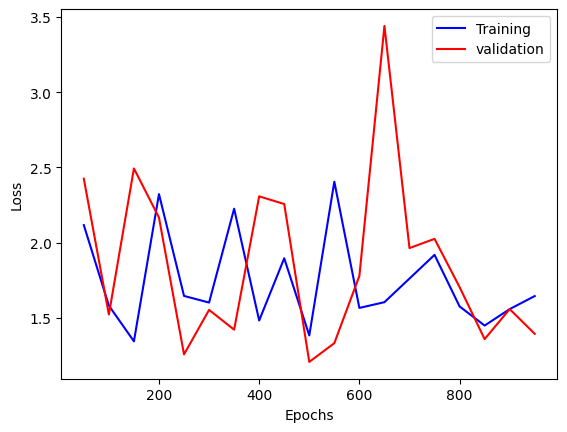

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import plotly.express as px
from dataclasses import dataclass

torch.manual_seed(10)



input_size =5
learning_rate = 0.003
max_iters = 1000
dataset_size = 2
sparsity = 0.1
batch_size = 16

iters = []
loss_value = []
val_loss_value = []


def sample_data(split = 'train'):
    if split != 'train':
        curr_data = validation_dataset
    else:
        curr_data = training_dataset
    sparsity_vector = sparsity
    a, b = curr_data.shape
    
    sparsity_vector = torch.rand(input_size)
    sparsity_vector = sparsity_vector.view(1, -1)
    sparsity_mat = torch.bernoulli(torch.full((a, b), 1.0) * sparsity_vector)
    
    X = curr_data * sparsity_mat
    return X, X



DEVICE = torch.device('cpu')

@dataclass
class Config:
    input_size : int = 10
    hidden_size : int = 10
    layers : int = 10

class Two_Two(nn.Module):
    def __init__(self, hidden_size) -> None:
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(hidden_size,hidden_size), nn.ReLU(), nn.Linear(hidden_size,hidden_size) )
    
    def forward(self, idx):
        return self.layers(idx)

class Model(nn.Module):
    def __init__(self, config : Config) -> None:
        super().__init__()
        self.config = config
        self.layers = nn.Sequential(
                        nn.Linear(config.input_size, config.hidden_size),
                        *[Two_Two(config.hidden_size) for i in range(config.layers)],
                        nn.Linear(config.hidden_size, config.input_size),
                    )

    
    def forward(self, idx : torch.Tensor):
        count = self.layers(idx)
        active = (idx>0).sum(-1)
        loss = nn.CrossEntropyLoss()
        
        return count, loss(count, active)


        

training_dataset = torch.rand(dataset_size, input_size)
validation_dataset = torch.rand(int(dataset_size/2), input_size)
output = input


model = Model(Config(input_size= input_size))


optimizer = torch.optim.Adam(model.parameters() , learning_rate, weight_decay= 1e-5)
start_time = time.time()
step_value = max_iters/20
for i in range(1, max_iters):
    X, Y = sample_data()
    count, loss = model(X)
   
    if i%step_value ==0 :
        model.eval()
        with torch.no_grad():
            X_V,Y_V = sample_data(split = 'val')
            _, val_loss= model(X_V)
            iters.append(i)
            loss_value.append(loss.item())
            val_loss_value.append(val_loss.item())
            print(f"iter:{i} training loss: {loss.item()}, val loss: {val_loss.item()}")
        model.train()

    optimizer.zero_grad(set_to_none=True)
    #loss+= get_l1_penalty()
    loss.backward()
    optimizer.step()


end_time = time.time()
print(f"Took {end_time-start_time}s for {max_iters} epochs")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(iters,loss_value, color='blue', label="Training")
plt.plot(iters, val_loss_value, "red", label = "validation")
plt.legend()
plt.show()

In [3]:
a,b = sample_data()

In [4]:
a[:5]

tensor([[0.0000, 0.0000, 0.3125, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6178,
         0.3304],
        [0.5479, 0.0000, 0.7041, 0.0000, 0.6959, 0.0000, 0.2924, 0.0000, 0.6150,
         0.4967]])

In [5]:
model(a[:5])

(tensor([[4.1430],
         [6.6717]], grad_fn=<ReluBackward0>),
 tensor(4.6719, grad_fn=<MeanBackward0>))

In [53]:
(a[:5]>0).sum(-1)

tensor([7, 4, 5, 6, 6])

In [8]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()


In [9]:
target

tensor([2, 4, 4])

In [10]:
input

tensor([[-1.1628,  0.8057,  1.4753,  0.1253,  0.4515],
        [ 0.4052, -0.8902, -0.0954,  0.1275,  0.6059],
        [ 0.5909,  0.4728, -0.7371,  0.5379, -0.0618]], requires_grad=True)

In [11]:
output

tensor(1.2930, grad_fn=<NllLossBackward0>)

In [18]:
idx = torch.rand(100,10)
active = (idx>0).sum(-1)

loss = nn.CrossEntropyLoss(count, active)

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [19]:
idx.shape, active.shape

(torch.Size([100, 10]), torch.Size([100]))

In [16]:
active

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10])